In [1]:
import sys
import torch
from torch import nn
import torch.backends.cudnn as cudnn
import random
import argparse
import numpy as np
from ResNet18 import ResNet18
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt
import dataloader_AffectNet as dataloader
import utils

In [2]:
def create_model(model_pth: str):
    model = ResNet18(do_regr=True, do_cls=False, variance=False, pretrained=True)
    state_dct = torch.load(model_pth, map_location=torch.device('cpu'))
    new_state = dict()
    for key in state_dct:
        new_state[key.replace('module.', '')] = state_dct[key]
    model.load_state_dict(new_state)
    model = model.cuda()
    return model

In [21]:
def get_hist(model):
    model.eval()
    clean_size, noisy_size = len(clean_loader.dataset), len(noisy_loader.dataset)
    clean_losses = torch.zeros(clean_size)
    noisy_losses = torch.zeros(noisy_size)
    with torch.no_grad():

        num_iter = clean_size // clean_loader.batch_size + 1
        for batch_idx, (inputs, targets, index) in enumerate(clean_loader):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            loss = PSLoss(outputs, targets)
            for b in range(inputs.size(0)):
                clean_losses[index[b]] = loss[b]
            sys.stdout.write('\r')
            sys.stdout.write('%s: Clean Data | Iter[%3d/%3d]' % ('Affectnet', batch_idx + 1, num_iter))
            sys.stdout.flush()
        print('\n')
        num_iter = noisy_size // noisy_loader.batch_size + 1
        for batch_idx, (inputs, targets, index) in enumerate(noisy_loader):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            loss = PSLoss(outputs, targets)
            for b in range(inputs.size(0)):
                noisy_losses[index[b]] = loss[b]
            sys.stdout.write('\r')
            sys.stdout.write('%s: Noisy Data | Iter[%3d/%3d]' % ('Affectnet', batch_idx + 1, num_iter))
            sys.stdout.flush()

    losses = torch.cat([clean_losses, noisy_losses])
    losses = (losses - losses.min()) / (losses.max() - losses.min())

    losses = losses.reshape(-1, 1)
    losses = losses.cpu().numpy()
    gmm = GaussianMixture(n_components=2, max_iter=50, reg_covar=5e-4, tol=1e-2)
    gmm.fit(losses)
    plt.hist(losses, bins=20, alpha=0.7, label='all', density=False)
    plt.hist(losses[clean_size:], bins=20, alpha=0.7, label='noisy', density=False)
    plt.legend()
    x = np.linspace(0, 1, 1000).reshape(-1, 1)
    logprob = gmm.score_samples(x)
    pdf = np.exp(logprob)
    plt.twinx()
    plt.plot(x, pdf, '-k', label='GMM')
    plt.legend()
    plt.show()

In [4]:
batch_size = 64
data_path='/import/nobackup_mmv_ioannisp/shared/datasets/AffectNet/'
cudnn.benchmark = True
PSLoss = nn.L1Loss(reduction='none')

clean_data = dataloader.AffectNetDataloader(
    batch_size=batch_size,
    num_workers=0,
    root_dir=data_path,
    log=None,
    artifitial_noise='clean'
)
noisy_data = dataloader.AffectNetDataloader(
    batch_size=batch_size,
    num_workers=0,
    root_dir=data_path,
    log=None,
    artifitial_noise='noisy'
)
clean_loader = clean_data.run(mode='eval_train')
noisy_loader = noisy_data.run(mode='eval_train')

Affectnet: Clean Data | Iter[2022/2022]

Affectnet: Noisy Data | Iter[322/322]

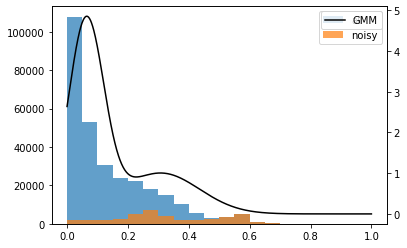

In [22]:
model_path = 'checkpoint/20210621_1500/affectnet_lr0.5_epoch1_ensemble0_model.pth'
net1 = create_model(model_path)
get_hist(net1)

Affectnet: Clean Data | Iter[2022/2022]

Affectnet: Noisy Data | Iter[322/322]

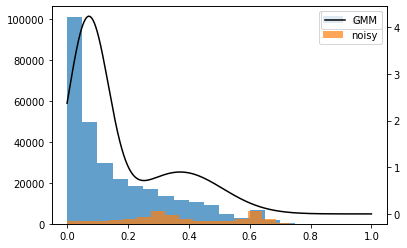

In [23]:
model_path = 'checkpoint/20210621_1500/affectnet_lr0.5_epoch4_ensemble0_model.pth'
net1 = create_model(model_path)
get_hist(net1)

Affectnet: Clean Data | Iter[2022/2022]

Affectnet: Noisy Data | Iter[322/322]

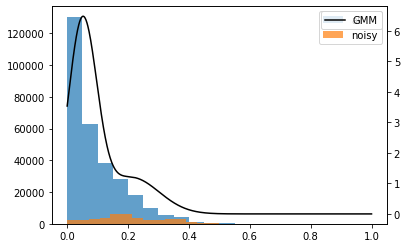

In [24]:
model_path = 'checkpoint/20210621_1743/affectnet_lr0.5_epoch9_ensemble0_model.pth'
net1 = create_model(model_path)
get_hist(net1)